# This is for multiple data (triplicate)

## The final CMC was calculated by the average of each ratio

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
from collections import defaultdict
from sklearn.linear_model import LinearRegression

In [3]:
def read_labsolutions_file(file_path):
    with open(file_path, encoding="utf-8") as f:
        lines = f.readlines()

    start_idx = None
    for i, line in enumerate(lines):
        if line.strip().startswith('"Wavelength nm."'):
            start_idx = i
            break

    df = pd.read_csv(file_path, skiprows=start_idx, header=0)
    return df

In [4]:
root = r"TYPE IN YOUR ROOT OF FOLDER HERE, THE ROOT SHOULD ONLY HAVE 3 FOLDERS" # Input your root here
folders = sorted([f for f in glob.glob(os.path.join(root, "*")) if os.path.isdir(f)])

results = defaultdict(dict)
for i, folder in enumerate(folders, start=1):
    rep = f"rep{i}" 
    all_files = glob.glob(os.path.join(folder, "*.txt"))

    for file in all_files:
        filename = os.path.basename(file)
        name = filename.replace(".txt", "").replace("(", "").replace(")", "").strip()
        try:
            conc = float(name)
            df = read_labsolutions_file(file)
            results[rep][conc] = df
        except ValueError:
            print(f"No conc detected: {filename}")


In [5]:
def format_conc(val):
    return ('{:.4f}'.format(val)).rstrip('0').rstrip('.')
for rep, conc_dict in results.items():
    plt.figure(figsize=(8, 5))
    for conc, df in sorted(conc_dict.items()):
        x = df.iloc[:, 0].to_numpy()
        y = df.iloc[:, 1].to_numpy()
        mask = (x >= 350) & (x <= 600)
        plt.plot(x[mask], y[mask], label=f"{format_conc(conc)} mg/mL")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    plt.legend(frameon=False)
    plt.show()

In [6]:
ratios = defaultdict(list)  # ratios[conc] = [rep1_ratio, rep2_ratio, rep3_ratio]

for rep, conc_dict in results.items():
    for conc, df in conc_dict.items():
        try:
            intensity_384 = df.iloc[:,1][df.iloc[:,0]==384].values[0]
            intensity_373 = df.iloc[:,1][df.iloc[:,0]==373].values[0]
            ratio = intensity_384 / intensity_373
            ratios[conc].append(ratio)
        except IndexError:
            print(f"⚠️ {rep} {conc} nm No data points for 384 or 373 found")


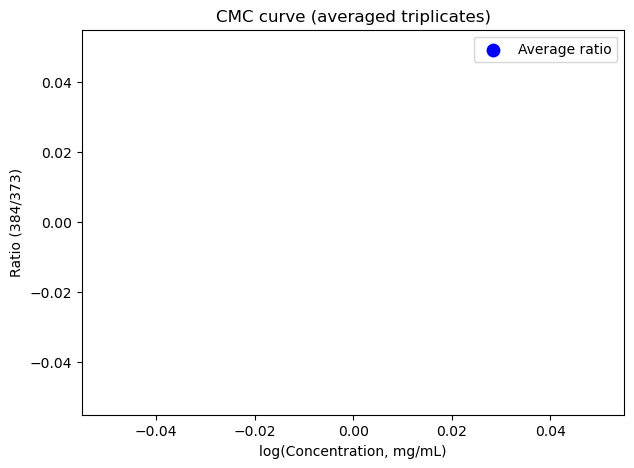

In [7]:
concs = sorted(ratios.keys())
x = np.log(concs)                  # x axis in log ver. if you dont want, just delete it
y = [np.mean(ratios[c]) for c in concs]

plt.figure(figsize=(7,5))
plt.scatter(x, y, color="blue", s=80, label="Average ratio")
plt.xlabel("log(Concentration, mg/mL)")
plt.ylabel("Ratio (384/373)")
plt.title("CMC curve (averaged triplicates)")
plt.legend()
plt.show()

In [8]:
def find_cmc_auto(x, y, min_points=3):

    best_err = np.inf
    best_split = None
    best_models = None

    for split_idx in range(min_points, len(x) - min_points):
        x1, y1 = x[:split_idx].reshape(-1,1), y[:split_idx]
        x2, y2 = x[split_idx:].reshape(-1,1), y[split_idx:]

        reg1 = LinearRegression().fit(x1, y1)
        reg2 = LinearRegression().fit(x2, y2)

        y1_pred = reg1.predict(x1)
        y2_pred = reg2.predict(x2)
        err = np.sum((y1 - y1_pred)**2) + np.sum((y2 - y2_pred)**2)

        if err < best_err:
            best_err = err
            best_split = split_idx
            best_models = (reg1, reg2)

    reg1, reg2 = best_models
    m1, b1 = reg1.coef_[0], reg1.intercept_
    m2, b2 = reg2.coef_[0], reg2.intercept_

    x_cmc = (b2 - b1) / (m1 - m2)
    cmc = np.exp(x_cmc)

    return cmc, best_split, (reg1, reg2, x_cmc)

x = np.log(concs)
y = np.array([np.mean(ratios[c]) for c in concs])

cmc, split_idx, (reg1, reg2, x_cmc) = find_cmc_auto(x, y)

print(f"Best split point: {split_idx}")
print(f"Calculated CMC ≈ {cmc:.4f} mg/mL")

plt.figure(figsize=(7,5))
plt.scatter(x, y, color="blue", s=80, label="Average ratio")


xx_all = np.linspace(min(x), max(x), 200).reshape(-1,1)

# Red line
yy1 = reg1.predict(xx_all)
plt.plot(xx_all, yy1, 'r--', label="low conc fit")

# Green line
yy2 = reg2.predict(xx_all)
plt.plot(xx_all, yy2, 'g--', label="high conc fit")

# Intercept
plt.scatter([x_cmc], [reg1.predict([[x_cmc]])], color="red", zorder=5, label="CMC")

plt.xlabel("log Concentration mg/mL$^{-1}$")
plt.ylabel("Ratio (384/373)")
plt.title("CMC determination")
plt.legend(frameon=False)
plt.show()

TypeError: cannot unpack non-iterable NoneType object